# Demo: Binary Classification

Create an initial dataset for a binary classification problem with 20 features:

- 6 of the features are informative
- 4 of the features are linear combinations of the informative features
- 10 of the features are just random noise


In [1]:
# Ignore lightgbm warnings
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries for the demo
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from shapfire import ShapFire, RefitHelper, plot_roc_curve

X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=6,
    n_redundant=4,
    n_repeated=0,
    n_classes=2,
    random_state=0,
    shuffle=False,
)
X = pd.DataFrame(data=X, columns=[f"feature{i}" for i in range(X.shape[1])])
X

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19
0,-0.056717,-0.493931,1.667702,1.397865,-0.794842,-0.682968,-0.511378,-0.992701,-0.248595,-1.676577,1.206354,2.321515,-1.423698,-0.433072,0.682042,-1.125577,-0.593864,-0.024779,1.735459,-1.113934
1,1.012914,-0.696091,0.414157,0.567214,0.729235,2.892775,-0.016728,-1.475205,3.680440,-2.095504,-0.676781,1.576879,-2.227987,1.638134,0.015417,-0.507376,1.178729,2.676799,0.344251,0.454819
2,1.690440,-1.236785,-0.507020,3.027518,-2.315026,2.067620,0.273264,1.017970,1.103050,-5.071645,-1.156792,-2.066161,-1.825515,-1.288961,0.324183,0.229208,-0.033722,0.727694,0.745335,-0.315728
3,2.035054,-1.154556,-0.012416,1.361509,-0.931541,2.933542,-0.734587,-0.335309,2.853751,-4.326141,-0.296359,1.215873,-0.278985,-1.448467,0.580039,0.156749,0.639724,0.029043,0.822496,1.151368
4,1.024961,-0.366287,2.079224,0.739798,-0.486162,0.621330,-1.945298,-1.429361,1.423769,-3.266301,2.028758,-2.972793,0.003815,-0.904622,-0.139921,-0.550930,-1.697206,0.102097,-1.056104,0.146621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.410788,0.250078,0.366037,1.168022,-0.056665,-0.251516,-0.505207,0.175348,0.103474,-1.987223,-0.384352,-1.023449,0.664366,0.745393,0.758317,1.200208,-0.147041,0.158603,-1.219479,-1.394935
996,-0.613218,1.423613,1.527973,-0.245896,-2.291340,0.481899,-2.839232,1.633723,-0.621871,-3.940202,0.300710,-0.307716,-0.349721,0.175795,0.228521,0.212923,0.732526,-0.404249,-0.448734,0.305272
997,-0.231221,1.140357,-2.173634,-1.429259,-1.838736,-0.198766,-0.784890,3.750921,-2.509571,-0.128341,-0.031324,-0.850717,0.361888,-0.409298,0.709181,1.040780,0.269000,0.130427,-0.856227,0.278540
998,-3.281446,-1.185517,1.473731,0.117330,-1.795964,1.482811,0.437157,-1.201846,0.767806,-0.192885,-1.765901,-1.326832,-1.287806,-0.353538,0.996278,2.046064,-0.360873,-0.720141,0.355115,-0.995815


## Dataset Split

Split the initial dataset into:

- A pre-processing dataset that we use for feature ranking and selection
- A final dataset which we use to obtain ROC AUC performance estimates using the selected features  

In [2]:
X_preprocess, X_final, y_preprocess, y_final = train_test_split(X, y, test_size=0.50, random_state=0)

## Feature Importance Ranking & Selection 


In [3]:
# Prepare input parameters for the ShapFire method
estimator_class=LGBMClassifier
estimator_params={"objective": "binary"}
scoring="roc_auc"
n_splits = 2
n_repeats= 5
sf = ShapFire(
  estimator_class=estimator_class,
  scoring=scoring,
  estimator_params=estimator_params,
  n_splits=n_splits,
  n_repeats=n_repeats,
)

# Perform feature importance ranking and selection
_ = sf.fit(X=X_preprocess, y=y_preprocess)

# Print the selected features
# Ideally, only the 10 first features should appear in the selected features 
for feature in sf.selected_features:
    print("Selected feature: ", feature)

Clustering progress 100%|=========================| 6.00/6.00 [00:00<00:00, 2.41kit/s]
ShapFire progress   100%|=========================| 20.0/20.0 [00:01<00:00, 13.0it/s]


Selected feature:  feature1
Selected feature:  feature7
Selected feature:  feature4
Selected feature:  feature0
Selected feature:  feature3
Selected feature:  feature9
Selected feature:  feature6
Selected feature:  feature8
Selected feature:  feature5


## Feature Importance Plot

To more easily get an overview of the ranked and selected features we can plot using the ShapFire class method: `plot_ranking`.

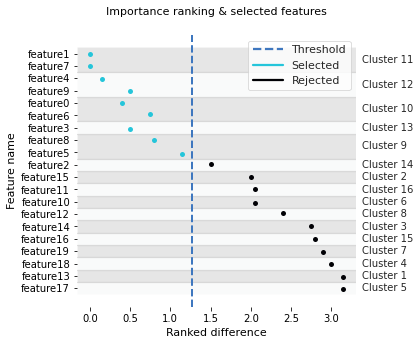

In [4]:
# Plot the selected features per cluster
fig, ax = sf.plot_ranking()

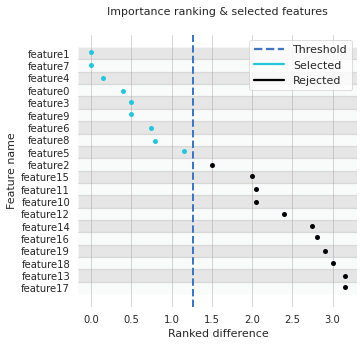

In [5]:
# Plot the selected features per feature
fig, ax = sf.plot_ranking(groupby="feature")

## Selcted Features: ROC Curves 

To get an unbiased estimate of the performance of a model that uses the previously **selected features**
we can perform repeated $k$-fold cross-validation on the other half of the initial dataset.


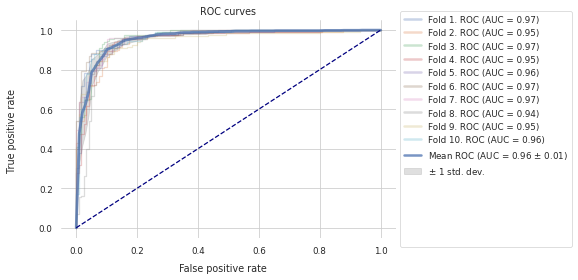

In [6]:
refit_helper_selected_features = RefitHelper(
    n_splits=n_splits,
    n_repeats=n_repeats,
    feature_names=sf.selected_features,
    estimator_class=estimator_class,
    estimator_params=estimator_params,
    scoring=scoring,
)
refit_helper_selected_features.fit(X_final, pd.Series(y_final))

_, _ = plot_roc_curve(df=refit_helper_selected_features.history)

## All Features: ROC Curves

Similarly, to get an unbiased estimate of the performance of a baseline model that is trained using **all initial features** we perform repeated $k$-fold cross-validation on the other half of the initial dataset.

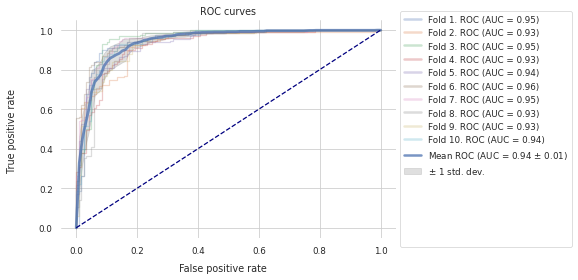

In [7]:
refit_helper_baseline_features = RefitHelper(
    n_splits=n_splits,
    n_repeats=n_repeats,
    feature_names=X.columns.to_list(),
    estimator_class=estimator_class,
    estimator_params=estimator_params,
    scoring=scoring,
)
refit_helper_baseline_features.fit(X_final, pd.Series(y_final))

_, _ = plot_roc_curve(df=refit_helper_baseline_features.history)